# Exercise Set 13: Network formation


In this Exercise Set 13 we will investigate network formation among high school pupils. 

## Part 1: Network formation


Load the data using the script below. Read a bit about the dataset [here](http://www.sociopatterns.org/datasets/high-school-contact-and-friendship-networks/) to get an understanding of what is in each variable. 

The script gives you two dataframes to work with: 
 > `el`, which is an edge-list 
 >
 > `ind` which contains individual characteristics

In [131]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

url_base = 'http://www.sociopatterns.org/wp-content/uploads/2015/'

# edgelist
url_el = url_base + '07/High-School_data_2013.csv.gz'
col_names_el = ['timestamp', 'u1', 'u2', 'class1', 'class2']
el = pd.read_csv(url_el, header=None, names=col_names_el, delimiter=' ')

# individual characteristics
url_ind = url_base + '09/metadata_2013.txt'
col_names_ind = ['u', 'class', 'gender']
ind = pd.read_csv(url_ind, header=None, names=col_names_ind, delimiter='\t')\
            .set_index('u')

# remove observation with missing gender
has_gender = ind[ind.gender!='Unknown'].index

# DataFrames
ind = ind.loc[has_gender].copy()
el = el[el.u1.isin(has_gender) &  el.u2.isin(has_gender)].copy()

In [132]:
el

,timestamp,u1,u2,class1,class2
0,1385982020,454,640,MP,MP
1,1385982020,1,939,2BIO3,2BIO3
2,1385982020,185,258,PC*,PC*
3,1385982020,55,170,2BIO3,2BIO3
4,1385982020,9,453,PC,PC
...,...,...,...,...,...
188503,1386345560,120,285,PC,PC
188504,1386345580,61,160,2BIO2,2BIO2
188505,1386345580,272,939,2BIO3,2BIO3
188506,1386345580,311,496,PC,PC


> **Ex. 13.1.1**: Describe the edgelist columns content. Parse the timestamp. What is the resolution of meetings? Use the parsed timestamp to count the meetings by hour in local time.

In [133]:
# [Answer to ex. 13.1.1 here]

In [134]:
#The EL dataframe has five variables. Timestamp is measured in seconds and expressed in Unix ctime. Each row is an edge between two nodes u1 and u2. They attend the same class.
el["timestamp"]=pd.to_datetime(el["timestamp"],unit='s')

# The resolution of the meetings are attending class. Thus, if they're attending class, they will meet the other pupils.
el

,timestamp,u1,u2,class1,class2
0,2013-12-02 11:00:20,454,640,MP,MP
1,2013-12-02 11:00:20,1,939,2BIO3,2BIO3
2,2013-12-02 11:00:20,185,258,PC*,PC*
3,2013-12-02 11:00:20,55,170,2BIO3,2BIO3
4,2013-12-02 11:00:20,9,453,PC,PC
...,...,...,...,...,...
188503,2013-12-06 15:59:20,120,285,PC,PC
188504,2013-12-06 15:59:40,61,160,2BIO2,2BIO2
188505,2013-12-06 15:59:40,272,939,2BIO3,2BIO3
188506,2013-12-06 15:59:40,311,496,PC,PC


In [135]:
# Counting number of meeting by hour in a new dataframe
meetings = el.groupby(pd.Grouper(key="timestamp", freq='h')).size().reset_index(name='meetings')
meetings

,timestamp,meetings
0,2013-12-02 11:00:00,5556
1,2013-12-02 12:00:00,4259
2,2013-12-02 13:00:00,6617
3,2013-12-02 14:00:00,5715
4,2013-12-02 15:00:00,5972
...,...,...
96,2013-12-06 11:00:00,4106
97,2013-12-06 12:00:00,3247
98,2013-12-06 13:00:00,1785
99,2013-12-06 14:00:00,2026


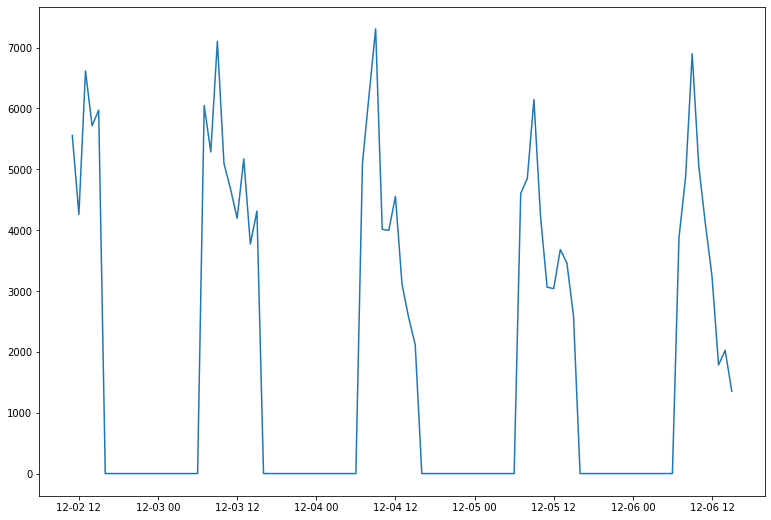

In [136]:
fig = plt.figure(figsize=(13,9))
ax = fig.add_subplot(111)
ax.plot(meetings.timestamp,meetings.meetings)

> **Ex. 13.1.2**: Count the number of meetings for each edge (node?) and save this as a DataFrame called `el_agg`. Filter out edges with less than 5 minutes of meetings. Attach the gender and class of both nodes.

In [137]:
# [Answer to ex. 13.1.2 here]
# Groupby u1 and u2 and count the number of meetings between them
el_agg = pd.DataFrame(el.groupby(['u1','u2']).size()).reset_index()

# Adding the class and gender of u 1 and 2 from df=ind and naming them respectively
el_agg = el_agg.merge(ind, left_on='u1', right_on='u') .rename(columns={'class':'class1','gender':'gender1'}) # u1
el_agg = el_agg.merge(ind, left_on='u2', right_on='u').rename(columns={'class':'class2','gender':'gender2'}) # u2

# Naming meet count column
el_agg = el_agg.rename(columns={0:'meet_count'})

el_agg

,u1,u2,meet_count,class1,gender1,class2,gender2
0,1,55,8,2BIO3,M,2BIO3,F
1,1,63,2,2BIO3,M,2BIO3,F
2,3,63,2,2BIO2,M,2BIO3,F
3,27,63,19,2BIO2,M,2BIO3,F
4,39,63,1,2BIO3,F,2BIO3,F
...,...,...,...,...,...,...,...
5578,866,1232,6,MP,M,MP*2,M
5579,1212,1232,6,MP*2,M,MP*2,M
5580,1214,1232,10,MP*2,M,MP*2,M
5581,1216,1232,1,MP*2,M,MP*2,M


The merge is such that it matches a u from df=ind to a u1 and u2 from el_agg. 

In [138]:
# Condition 
Condition = el_agg[ el_agg['meet_count'] < 3*5 ].index # 3*5 as 3 * 20 seconds * 5

# Delete these row indexes from dataFrame
el_agg.drop(Condition , inplace=True)

In [139]:
el_agg

,u1,u2,meet_count,class1,gender1,class2,gender2
3,27,63,19,2BIO2,M,2BIO3,F
13,70,101,15,2BIO3,F,2BIO3,F
17,55,106,28,2BIO3,F,2BIO3,F
20,101,106,23,2BIO3,F,2BIO3,F
21,1,117,18,2BIO3,M,2BIO3,M
...,...,...,...,...,...,...,...
5524,366,1485,23,MP*1,M,MP*2,M
5563,1332,1819,120,MP*2,F,MP*2,M
5570,1423,1819,62,MP*2,M,MP*2,M
5574,1594,1819,129,MP*2,F,MP*2,M


> **Ex. 13.1.3**: Answer question in the function `fraction_triangles` below. Explain how `fraction_triangles` is related to  computing the clustering coefficient (using `nx.average_clustering`).
>
>> *Hint:* The following code does the same thing as `fraction_triangles`, but at a scale where you can understand what's going on. If you have a hard time understanding the code in the function you can try to play around with this simpler example
>>
>> ```python
>> import networkx as nx 
>>
>> A  = np.array(
>>     [[0, 1, 1, 0],
>>      [1, 0, 1, 0],
>>      [1, 1, 0, 1],
>>      [0, 0, 1, 0]]
>> )
>>
>> G = nx.from_numpy_array(A)
>> nx.draw(G,with_labels=True)
>>
>> def nth(A, n):
>>     A_ = A.copy()    
>>     for _ in range(1,n):
>>         A = A.dot(A_)
>>     return A
>>
>> a_t = nth(A,3).diagonal().sum()/6
>> n = len(A[:,0])
>> p_t = binom(n, 3)
>> ```


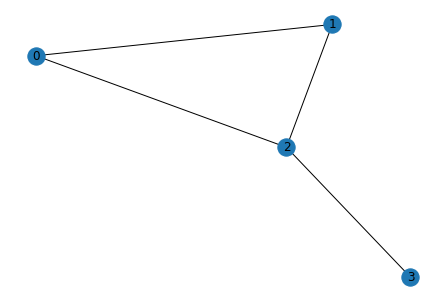

In [140]:
# Each row is a node, and every 1 is an edge
A  = np.array(
    [[0, 1, 1, 0],
     [1, 0, 1, 0],
     [1, 1, 0, 1],
     [0, 0, 1, 0]]
)

G = nx.from_numpy_array(A)
nx.draw(G,with_labels=True)

def nth(A, n):
    A_ = A.copy()    
    for _ in range(1,n):
        A = A.dot(A_)
    return A

a_t = nth(A,3).diagonal().sum()/6
n = len(A[:,0])
p_t = binom(n, 3)

In [142]:
def make_net(el_, nodes):
    '''
    Convert edgelist to networkx graph which is 
    binary and undirected.
    
    Parameters
    ----------
    el_ : DataFrame
        Table containing an edgelist with columns 
        `u1` and `u2` which are the nodes in the edge.
        
    nodes : array-like
        1d array containing the node identities.
    '''    
    
    nx_input = el_, 'u1', 'u2', 'meet_count', nx.Graph()
    g = nx.from_pandas_edgelist(*nx_input)
    g.add_nodes_from(nodes)
    return g

In [143]:
from scipy.special import binom

def fraction_triangles(el_, nodes):
    '''
    Compute fraction of actual triangles out 
    of the potential triangles.
    
    Parameters
    ----------
    el_ : DataFrame
        Table containing an edgelist with columns 
        `u1` and `u2` which are the nodes in the edge.
        
    nodes : array-like
        1d array containing the node identities.
    '''
    
    g = make_net(el_, nodes)
    
    #Q.1: what is `A`?: the adjacency matrix which is symmetric and binary
    # Each row presents a node, it's binary such that if a column in a row = 1, then it has an edge to another node. From wiki "it's a square matrix used to present a finite graph. The elements of the matrix indicate whether pairs of vertices are adjacent or not in the graph."
    #Q.2: what does `A**3` do? compute the number of paths between two nodes
    #Q.3: what is diagonal of A_t? the number of actual paths of length 3, 
    # i.e. triangles, which include the person. these are called cycles
    # because they start and end at the same person
    # The diagonal of the matrix is 0. The matrix i symmetric.
    
    # count actual triangles    
    A = nx.to_scipy_sparse_matrix(g)
    A_t = A**3
    a_t = A_t.diagonal().sum()/6
    
    #Q.4: what does `binom(n,3)` compute? the number of triangles including the person
    
    # count potential triangles
    n = len(g.nodes())
    p_t = binom(n, 3)
        
    return a_t/p_t

> **Ex. 13.1.4**: Apply the function `fraction_triangles` to `el_agg` and print the triangle fraction in the network. Next remove all edges that go between classes. Compute triangle fraction within each class and store it. Compute the mean within class triangles and bootstrap the standard error of the mean. Comment on the output.
>
>> *Hint:* To bootstrap an estimate draw $k>>0$ samples with replacement from the data. Compute the estimate on each of these samples and average them in the end to get the bootstrapped estimate. 

In [144]:
# [Answer to ex. 13.1.4 here]

# Computing fraction triangles for the network
print('Fraction triangles = ',round(fraction_triangles(el_agg,el_agg['u1']),10))


Fraction triangles =  0.0003160279


In [145]:
# Drop rows if class1 != class 2
Condition1 = el_agg[ el_agg['class1'] != el_agg['class2'] ].index

# Drop if condition 1 is met
el_agg.drop(Condition1 , inplace=True)

In [146]:
print('n without edges between classes', el_agg.shape[0])

n without edges between classes 1217


In [147]:
# Compute triangle fraction within each class and store it. 

# Initiating dict for a new column
class_values = {}

# Initiating for loop which goes through unique classes
for class_name in el_agg['class1'].unique():
    
    # Data frame with unique classes
    df = el_agg.loc[el_agg['class1'] == class_name]
    
    # Using the classes as row index and calculating fraction triangle for each class in the new column
    class_values.update( {'{}'.format(class_name) : fraction_triangles(df,df['u1'])} )   
class_t = pd.DataFrame(pd.Series(class_values)).rename(columns={0:'{}'.format(fraction_triangles.__name__)})

print('Mean of class fraction triangles',np.mean(class_t['fraction_triangles']))
class_t

Mean of class fraction triangles 0.023346781467678452


,fraction_triangles
2BIO3,0.034717
MP,0.029830
MP*2,0.028094
2BIO2,0.034274
2BIO1,0.013293
PC*,0.019820
PSI*,0.010814
PC,0.023407
MP*1,0.015873


In [148]:
# Computing the bootstraped std. error of the mean
def bootstrap(df,pd_function):
    # Initiating list
    l = []
    # n is int shape of dataframe divided by three
    n = int(df.shape[0]/3)
    for i in range(100):
        if pd_function == 'mean':
            l.append(df.sample(n=n, replace=True).mean())
        if pd_function == 'sem':
            l.append(df.sample(n=n, replace=True).sem())
    return sum(l)/len(l)

In [149]:
print('Bootstrapped mean:', bootstrap(class_t,'mean'))
print('Bootstrapped std. error of mean:', bootstrap(class_t,'sem'))

Bootstrapped mean: fraction_triangles    0.023157
dtype: float64
Bootstrapped std. error of mean: fraction_triangles    0.004397
dtype: float64


Recall from class that we can define the following measures of homophily. We define **homophily index** inspired by [Currarini et al. (2009)](https://doi.org/10.2139/ssrn.1021650):
- share of edges that are same type: $H = \frac{s}{s+d}$
- possible range [0,1]


We define **baseline homophily** as: 
- We count fraction of potential edges in population of nodes which are same type:

\begin{equation}B=\frac{\sum_t\#potential(n_t)}{\#potential(n)}, \qquad \#potential(k)=\frac{k\cdot(k-1)}{2}\end{equation}

- Interpretation: Expected homophily from random link formation.     

We define **inbreeding homophily** as:      

\begin{equation}IH=\frac{H-B}{1-B}\end{equation}


> **Ex. 13.1.5**: Compute the inbreeding homophily for each class. Use the class measures to compute the mean. Use a bootstrap to compute whether there is inbreeding homophily.

In [150]:
# [Answer to ex. 13.1.5 here]
# Defining the function of homophily
def i_homophily(df, type1, type2):
    # Defining same type column, where type 1 equals 2
    df['same_type'] = type1.eq(type2)
    # Counting same and different types
    s = df['same_type'][df['same_type'] == True].count()
    d = df['same_type'][df['same_type'] == False].count()
    H = s / (s + d)

    def potential(k):
        return (k*(k-1))/2

    B = potential(s) / potential(df.shape[0])

    return (H - B) / (1 - B)

In [151]:
class_values = {}
for class_name in el_agg['class1'].unique():
    df = el_agg.loc[el_agg['class1'] == class_name]
    class_values.update( {'{}'.format(class_name) : i_homophily(df,df['gender1'], df['gender2'])})   
class_t = pd.DataFrame(pd.Series(class_values)).rename(columns={0:'{}'.format(i_homophily.__name__)})

print(class_t)
print('\n')
print('Boostrapped mean: %.3f' %bootstrap(class_t,'mean'))
print('Boostrapped st.error of mean: %.3f' %bootstrap(class_t,'mean'))

i_homophily
2BIO3     0.406433
MP        0.398734
MP*2      0.420495
2BIO2     0.377990
2BIO1     0.396648
PC*       0.400862
PSI*      0.375000
PC        0.359517
MP*1      0.404959


Boostrapped mean: 0.396
Boostrapped st.error of mean: 0.394


> **Ex. 13.1.6** (BONUS): Describe what an unsupported edge is. Construct a test of whether there is a preference for forming  triangles within same gender than across.
>
>> *Hint:*  You can find inspiration in the approach of [Chandrasekhar, Jackson (2018)](https://web.stanford.edu/~arungc/CJ_sugm.pdf) pp. 31-35. They construct an almost identical test for triangle formation across castes in Indian villages.

In [152]:
# [Answer to ex. 13.1.6 here]